In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from scipy.integrate import dblquad

from correlation import (
    create_buckets, 
    calc_contingency_table, 
    chi_squared_statistic
)
from utils import plot_contingency_table

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv('data/fake_insurance_data.csv')
df.head(10)

,car_color,driver_age,area,mileage,car_size
0,black,26.377219,suburbs,156806.288398,XXL
1,black,58.976840,suburbs,74400.323559,XL
2,multicolor,55.744988,downtown,267856.748015,XXL
3,metalic,57.629139,downtown,259028.249060,XXL
4,green,21.490637,downtown,110712.216080,XL
5,gray,50.052691,downtown,166848.529135,XXL
6,black,27.849175,suburbs,27533.843483,XL
7,blue,42.927957,hills,189280.320650,XL
8,metalic,73.966067,hills,180140.764820,XXL
9,gray,18.988367,downtown,183291.533883,XXL


# Ssplit into buckets

In [3]:
buckets, bucket2interval = create_buckets(df['driver_age'].values, bins=10)
bucket2interval

{1: '18.031 - 28.345',
 2: '28.345 - 38.660',
 3: '38.660 - 48.974',
 4: '48.974 - 59.289',
 5: '59.289 - 69.603',
 6: '69.603 - 79.918',
 7: '79.918 - 90.232',
 8: '90.232 - 100.547',
 9: '100.547 - 110.862',
 10: '110.862 - 121.176'}

# Contingency table

In [4]:
ctable, meta = calc_contingency_table(
    x=df['driver_age'].values,
    y=df['car_color'].values, 
    xbins=15,
    ybins=15,
    xlabel='driver_age',
    ylabel='car_color'
)
ctable

array([[71, 77, 72, 33,  9,  0,  0,  0],
       [86, 71, 53, 33, 13,  4,  0,  0],
       [74, 65, 40, 39, 21,  6,  0,  0],
       [76, 64, 48, 46, 32, 24,  0,  0],
       [52, 42, 28, 33, 32, 20,  7,  0],
       [36, 34, 30, 33, 31, 35, 23,  1],
       [24, 24, 28, 31, 27, 26, 29,  4],
       [12, 16, 10, 17, 16, 20, 30, 17],
       [12, 16, 10,  4, 14,  9, 14, 15],
       [ 9,  5,  5,  8,  5,  4,  6,  5],
       [ 7,  4,  3,  1,  1,  1,  0,  0],
       [ 6,  1,  3,  2,  0,  1,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  1,  0,  0,  0]])

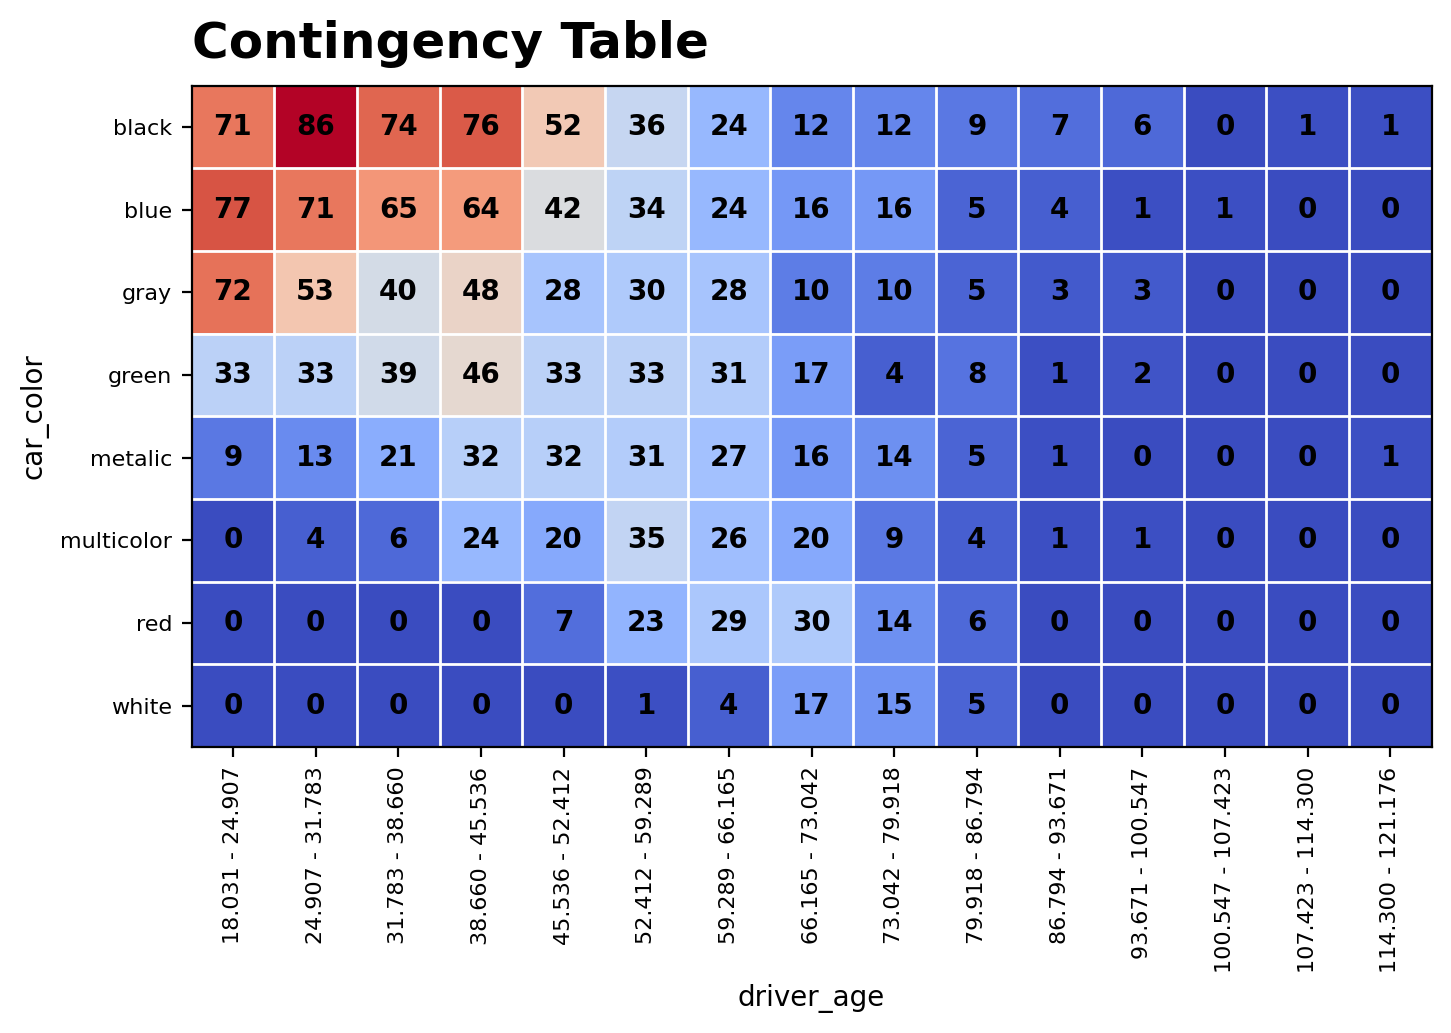

In [5]:
plot_contingency_table(table=ctable, meta=meta)

# Chi-squared statistic

In [6]:
chi_squared_statistic(table=ctable)

657.887803178695

# Bi-variate normal distribution

In [23]:
def generate_binorm_distr(rho):
    """
    Generate data for a bivariate normal distribution 
    with a specified correlation coefficient (rho).
    """
    # gererate a grid
    x, y = np.mgrid[-3:3:0.05, -3:3:0.05]
    pos = np.dstack((x, y))

    mu = np.array([0.0, 0.0])
    sigma = np.array([[1.0, rho], [rho, 1.0]])
    pdf = multivariate_normal(mean=mu, cov=sigma, seed=0).pdf(pos)

    return x, y, pdf

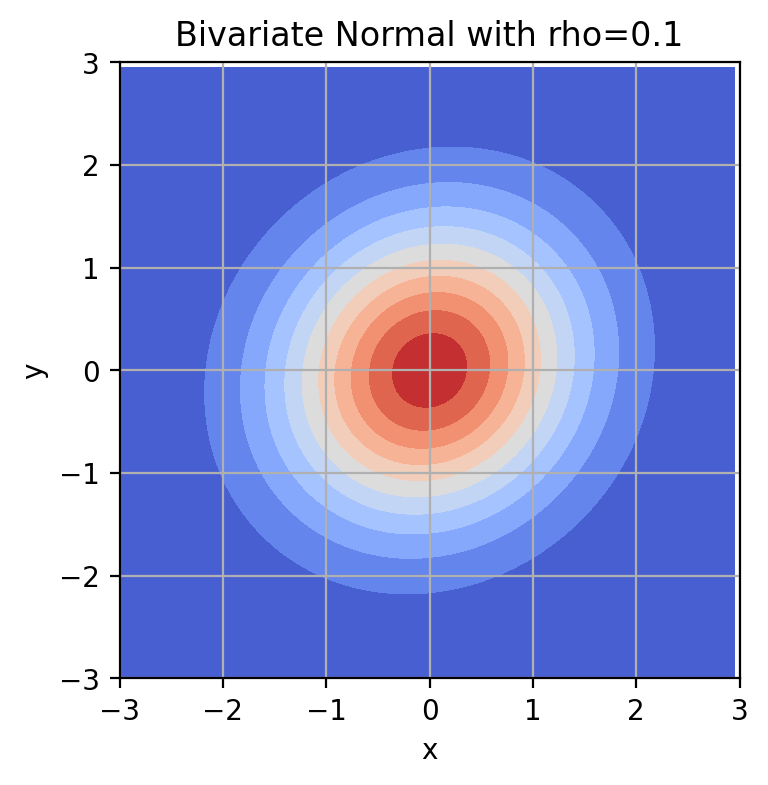

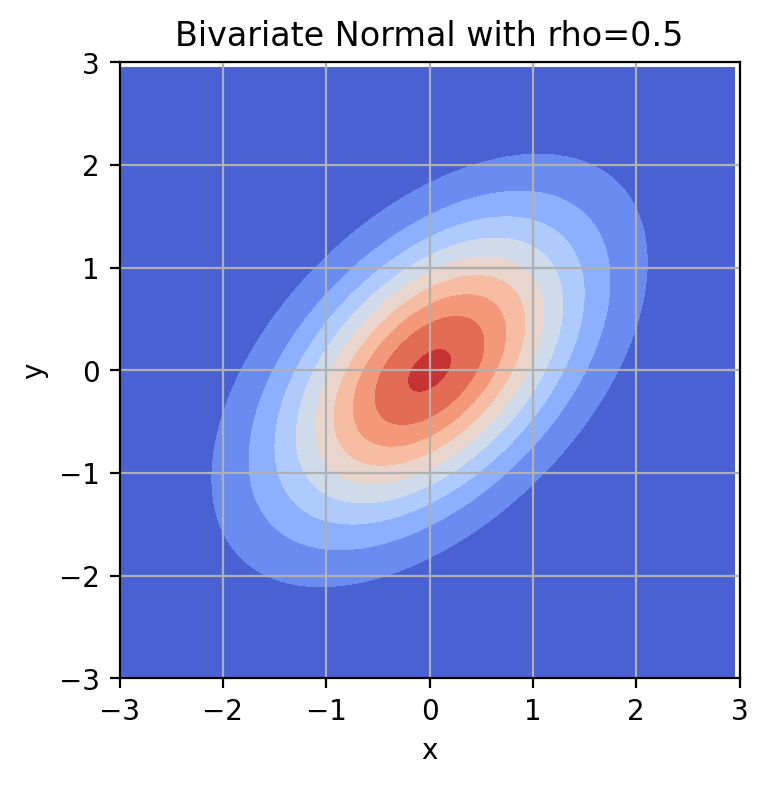

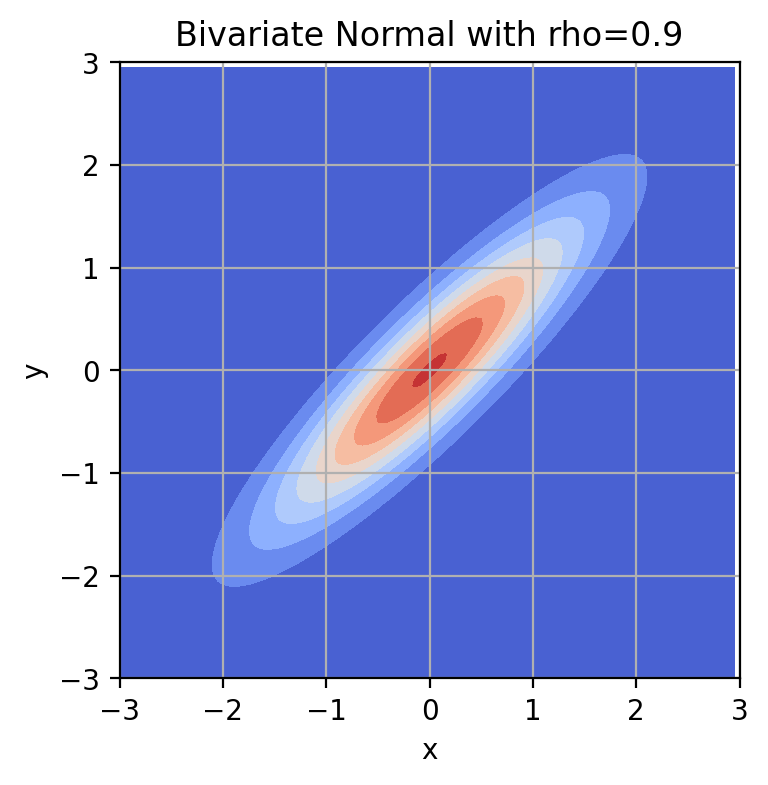

In [24]:
rhos = [0.1, 0.5, 0.9]

for i, rho in enumerate(rhos):
    x, y, pdf = generate_binorm_distr(rho)
    
    plt.figure(figsize=(4,4))
    plt.contourf(x, y, pdf, levels=10, cmap='coolwarm')
    plt.title(f'Bivariate Normal with rho={rho}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim((-3,3))
    plt.ylim((-3,3))
    plt.grid()
    plt.show()

In [28]:
# def integrate_bivariate_normal(grid_area, rho):
#     """
#     To calculate the probability mass function (PMF) of a bivariate normal distribution for a specific area, 
#     we need to perform a double integral over that area. The PMF represents the probability that a random variable 
#     falls within a given range or region.
#     """
#     xmin, xmax, ymin, ymax = grid_area
#     x, y, pdf = generate_binorm_distr(rho)
    
#     # Define the function to be integrated
#     f = lambda x, y: multivariate_normal(mean=[0, 0], cov=[[1, rho], [rho, 1]]).pdf([x, y])
    
#     # Perform the double integral over the specified region
#     integral, _ = dblquad(f, xmin, xmax, ymin, ymax)
    
#     return integral

In [25]:
# from tqdm import tqdm 

# xmin, xmax = -2, 2
# ymin, ymax = -2, 2
# step = 1.0

# xgrid = np.arange(xmin, xmax + step, step)
# ygrid = np.arange(ymin, ymax + step, step)

# grid_pairs = []
# for xmin in tqdm(xgrid):
#     for xmax in xgrid:
#         for ymin in ygrid:
#             for ymax in ygrid:
#                 if xmin < xmax and ymin < ymax:
#                     grid_pairs.append((xmin, xmax, ymin, ymax))

# len(grid_pairs)

In [26]:
# chi2 = 0
# for area_ij in tqdm(grid_pairs):
#     f_ij_rho = integrate_bivariate_normal(grid_pairs[0], rho=0.7)
#     f_ij_0 = integrate_bivariate_normal(grid_pairs[0], rho=0.0)
#     chi2 += (f_ij_rho - f_ij_0)**2 / f_ij_0
# chi2 *= ctable.sum()

In [27]:
# chi2